# Neural Network with one hidden layer
In this notebook I will implement a neural network with one hidden layer. This NN will then be used to classify the digital figures from [MNIST database](http://yann.lecun.com/exdb/mnist/). The output layer would be activated using "softmax" since the output is not just 0 or 1. 

## 1. Packages

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
# data dims
print('training set dimensions: ' + str(x_train.shape))
print('training label dimensions: ' + str(y_train.shape))
print('test set dimensions: ' + str(x_test.shape))
print('test label dimensions: ' + str(y_test.shape))

training set dimensions: (60000, 28, 28)
training label dimensions: (60000,)
test set dimensions: (10000, 28, 28)
test label dimensions: (10000,)


### 1.1 helper functions
- sigmoid
- relu
- softmax

In [39]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x)), x
def relu(x):
    return np.maximum(0, x), x
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x)), x

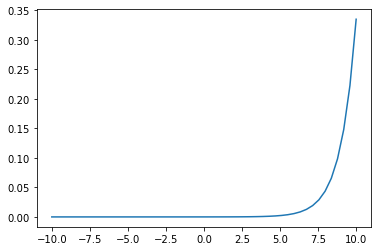

In [41]:
# test helper functions
x = np.linspace(-10, 10)
plt.plot(x, softmax(x)[0])

## 2. Initialize parameters

In [92]:
def initialize_parameters(layer_dims):
    """
    Initialize the parameters W's and b's.
    
    Argument:
    layer_dims -- an array of layer dimensions [n0, n1, ..., nL]
    
    Returns:
    parameters -- a dictionary of initialized parameters
                    W1: random
                    b1: zeros
                    ...
                    WL: random
                    bL: zeros
    """
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L):
        parameters['W'+str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b'+str(l)] = np.zeros((layer_dims[l], 1))
    
    return parameters

In [74]:
# test initialize_parameters()
layer_dims = [5, 4, 1]
parameters = initialize_parameters(layer_dims)
print(parameters)

{'W1': array([[ 0.70489977,  2.02850029,  0.34440333,  1.11052513, -1.08081652],
       [ 1.21532409, -1.5404018 ,  1.55449119, -1.18478207, -0.25581854],
       [-1.44603519,  0.16279023, -0.52684983, -0.93217436, -1.31376191],
       [ 0.65892708,  0.3836431 , -1.49557389,  0.37448568,  1.58956988]]), 'b1': array([[0.],
       [0.],
       [0.],
       [0.]]), 'W2': array([[ 1.70136281,  2.4908491 , -0.00452855,  1.52846754]]), 'b2': array([[0.]])}


## 3. Forward propagation

In [11]:
# linear forward
def linear_forward(A_prev, W, b):
    """
    The linear part of forward propagation: Z = WA + b
    
    Argument:
    A_prev -- the activitions of previous step (X for the first hidden layer)
    W, b -- parameters 
    
    Returns:
    Z -- result of linear forward propagation
    cache -- cache A_prev and the parameters W and b for convenience when calculating backpropagation
    """
    
    Z = W @ A_prev + b
    cache = (A_prev, W, b)
    
    return Z, cache

In [60]:
# test linear forward
layer_dims = [5, 4, 1]
parameters = initialize_parameters(layer_dims)
A_prev = np.array([1, 2, 3, 4, 5]).reshape((5, 1))
W = parameters['W1']
b = parameters['b1']
Z, cache = linear_forward(A_prev, W, b)
print('Z: ' + str(Z))
print('cache: ' + str(cache))

Z: [[ 0.07496603]
 [-1.29750846]
 [-6.51086663]
 [14.86836287]]
cache: (array([[1],
       [2],
       [3],
       [4],
       [5]]), array([[ 0.24231137,  0.79358088,  0.64267379, -1.6697503 ,  0.59929455],
       [ 0.68962104, -0.73433347,  0.65714267,  0.55391356, -0.94110896],
       [-1.43654678, -0.07274414, -2.67653623,  0.34781203,  0.34190581],
       [-1.09771533, -1.82268597,  1.91273632,  0.89321228,  2.06007841]]), array([[0.],
       [0.],
       [0.],
       [0.]]))


In [90]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Forward propagation including both linear mapping and activation
    
    Argument:
    A_prev -- the activations of previous step (X for the first hidden layer)
    W, b -- parameters
    activation -- activation function used in this layer
    
    Returns:
    A -- The activation values of current layer
    cache -- A tuple containing both caches from linear part and activation part, (linear_cache, activation_cache)
                where linear_cache is (A_prev, W, b), and activation_cache is Z
    """
    
    assert(W.shape[1]==A_prev.shape[0])
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == 'relu':        
        A, activation_cache = relu(Z)
    elif activation == 'sigmoid':
        A, activation_cache = sigmoid(Z)
    elif activation == 'softmax':
        A, activation_cache = softmax(Z)
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [47]:
# test linear_activation_forward
layer_dims = [5, 4, 1]
parameters = initialize_parameters(layer_dims)
A_prev = np.array([1, 2, 3, 4, 5]).reshape((5, 1))
W = parameters['W1']
b = parameters['b1']
A, cache = linear_activation_forward(A_prev, W, b, activation='softmax')
print("A: " + str(A))
print("cache: " + str(cache))

A: [[9.15843267e-01]
 [4.81944495e-02]
 [3.58630571e-02]
 [9.92262631e-05]]
cache: ((array([[1],
       [2],
       [3],
       [4],
       [5]]), array([[ 0.33024446,  0.69524729,  0.18531272, -0.41053868,  0.52340408],
       [-0.03743498, -0.20204586,  1.31900975, -1.02470386,  0.17805087],
       [-0.39225625,  0.94519371, -0.54069818,  0.42527993, -0.31315021],
       [-0.3966761 ,  1.50437164, -0.33590766, -0.91941424, -0.76106843]]), array([[0.],
       [0.],
       [0.],
       [0.]])), array([[ 3.25154286],
       [ 0.30694147],
       [ 0.01140533],
       [-5.87865494]]))


In [86]:
def L_model_forward(X, parameters):
    """
    Use current parameters to calculate the output layer value AL.
    
    Arguments:
    X -- input data
    parameters -- a dictionary containing W and b
    
    Returns:
    AL -- output layer values 
    caches -- a list of cache, returned by linear_activation_forward() at each layer
    """
    
    caches = []
    L = int(len(parameters) / 2)
    A_prev = X
    for l in range(1, L):
        A_prev, cache = linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], activation='relu')
        caches.append(cache)
    
    # Last layer
    AL, cache = linear_activation_forward(A_prev, parameters['W'+str(L)], parameters['b'+str(L)], activation='softmax')
    caches.append(cache)
    
    return AL, caches

In [93]:
layer_dims = [5, 4, 3]
parameters = initialize_parameters(layer_dims)
X = np.array([1, 2, 3, 4, 5]).reshape((5, 1))
AL, caches = L_model_forward(X, parameters)
print('AL: ' + str(AL))
print('caches: ' + str(len(caches)))

AL: [[0.33328926]
 [0.33340757]
 [0.33330317]]
caches: 2


## 4. Compute cost

In [101]:
def compute_cost(AL, Y):
    """
    Compute the cost function of softmax activation
    
    Argument:
    AL -- hypothesis of the model
    Y -- training labels
    
    Returns:
    cost -- the value of cost function
    """
    m = AL.shape[1]
    cost = -1/m * np.sum(Y*np.log(AL))
    cost = np.squeeze(cost)
    return cost

In [102]:
layer_dims = [5, 4, 3]
parameters = initialize_parameters(layer_dims)
X = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]).reshape((5, 2))
Y = np.array([1, 0, 0, 0, 0, 1]).reshape((3, 2))
AL, caches = L_model_forward(X, parameters)
cost = compute_cost(AL, Y)
print('cost: ' + str(cost))

cost: 1.7919430854803733


## 5. Backward propagation

In [104]:
def linear_backward(dZ, cache):
    """
    Linear part of the backward propagation: 
    dW = 1/m * dZ * dA_prev.T (n[l], n[l-1]) (n[l], m) (n[l-1], m)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    
    Args:
    dZ -- derivative of cost function with respect to Z
    cache -- cache from linear forward propagation, (A, W, b)
    
    Returns:
    grads -- gradients used for gradient descent
    """
    
    m = dZ.shape[1]
    dA_prev = cache[0]
    
    dW = 1/m * dZ @ dA_prev.T
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    
    grads = {'dW': dW,
             'db': db}
    
    return grads    

In [106]:
dZ = np.array([1, 2, 3]).reshape((3, 1))
cache = (np.random.randn(4, 1), 0, 0)
grads = linear_backward(dZ, cache)
print('grads: ' + str(grads))

grads: {'dW': array([[ 0.85210537,  1.06147179,  0.26176881, -0.95751962],
       [ 1.70421073,  2.12294357,  0.52353762, -1.91503923],
       [ 2.5563161 ,  3.18441536,  0.78530643, -2.87255885]]), 'db': array([[1.],
       [2.],
       [3.]])}


In [ ]:
def linear_activation_backward(dA, cache, activation):
    """
    Linear + activation parts, whole backward propagation dA -> dA_prev
    
    Args:
    dA -- derivative of cost function with respect to A
    cache -- cache from linear activation forward propagation, (linear_cache, activation_cache)
    
    Returns:
    grads -- gradients used for gradient descent
    """
    linear_cache, activation_cache = cache
    
    if activation == 'sigmoid':
        dZ = sigmoid_backward(dA)
    elif activation == 'relu':
        dZ = relu_backward(dA)
    elif activation == 'softmax':
        dZ = softmax_backward(dA)
        
    

## 6. Update parameters